# Part 1:
####  Scenario where the user has purchase history and we recommend similar items to the user
Model-based collaborative filtering system Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
amazon_ratings = pd.read_csv('Data/ratings_Beauty.csv')
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [3]:
amazon_ratings = amazon_ratings.drop('Timestamp',axis=1)
amazon_ratings.isna().sum()

UserId       0
ProductId    0
Rating       0
dtype: int64

In [4]:
amazon_ratings.shape

(2023070, 3)

In [5]:
# Subset of Amazon Ratings
amazon_ratings_sub = amazon_ratings.head(9999)

In [6]:
ratings_utility_matrix = amazon_ratings_sub.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = ratings_utility_matrix.T

# Normalize the data
scaler = StandardScaler()
matrix_norm = scaler.fit_transform(X)

In [8]:
# Convert to sparse matrix format
matrix_norm_sparse = csr_matrix(matrix_norm)

In [9]:
# Apply Truncated SVD
SVD = TruncatedSVD(n_components=10, random_state=42)
decomposed_matrix = SVD.fit_transform(matrix_norm_sparse)
print(f'Decomposed matrix shape: {decomposed_matrix.shape}')

Decomposed matrix shape: (886, 10)


In [10]:
# Compute the correlation matrix
correlation_matrix = cosine_similarity(decomposed_matrix)
print(f'Correlation matrix shape: {correlation_matrix.shape}')

Correlation matrix shape: (886, 886)


In [11]:
# Choose a product index (example: 100th product)
i = X.index[100]
print(f'Selected product: {i}')

Selected product: 6117043058


In [12]:
# Find the product ID
product_names = list(X.index)
product_ID = product_names.index(i)
print(f'Product ID: {product_ID}')

Product ID: 100


In [13]:
# Get the correlation scores for the selected product
correlation_product_ID = correlation_matrix[product_ID]
print(f'Correlation scores shape: {correlation_product_ID.shape}')

Correlation scores shape: (886,)


In [14]:
# Recommend products with high correlation scores
Recommend = list(X.index[correlation_product_ID > 0.90])

In [15]:
# Remove the item already bought by the customer
if i in Recommend:
    Recommend.remove(i)

In [16]:
# Display top recommendations
print(f'Recommended products: {Recommend[0:9]}')

Recommended products: ['0205616461', '0558925278', '0733001998', '0737104473', '0762451459', '1304139212', '1304139220', '130414089X', '130414643X']


In [45]:
# Calculate Recommendation Coverage
def recommendation_coverage(recommended_items, total_items):
    coverage = len(set(recommended_items)) / float(total_items) * 100
    return coverage

# Apply inverse transformation to get back to the original space
reconstructed_matrix = np.dot(decomposed_matrix, SVD.components_)

# Calculate Model Performance (MSE or RMSE)
def model_performance(original_matrix, reconstructed_matrix):
    mse = np.mean((original_matrix - reconstructed_matrix)**2)
    rmse = np.sqrt(mse)
    return mse, rmse


coverage = recommendation_coverage(Recommend, len(X))

mse, rmse = model_performance(matrix_norm, reconstructed_matrix)

print(f'Recommendation Coverage: {coverage:.2f}%')
print(f'Model Performance - MSE: {mse:.4f}, RMSE: {rmse:.4f}')

Recommendation Coverage: 94.92%
Model Performance - MSE: 0.6816, RMSE: 0.8256


# Part 2:
#### Scenario where a business without any user-item purchase history and we recommend similar items to the search user does
For a business without any user-item purchase history, a search engine based recommendation system can be designed for users. The product recommendations can be based on textual clustering analysis given in product description.

Optimal number of clusters (K-Means): 14


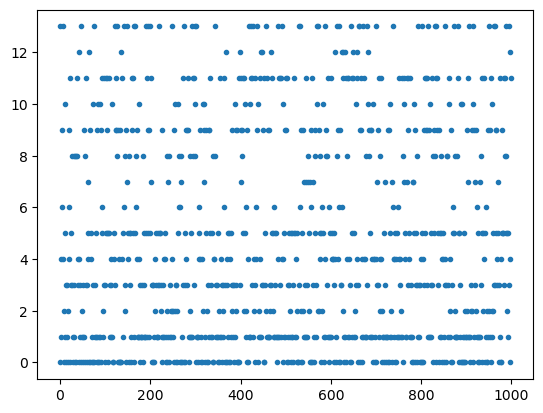

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load and preprocess data
product_descriptions = pd.read_csv('product_descriptions.csv').dropna()
product_descriptions1 = product_descriptions.head(1000)

# Text Vectorization with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5)
X1 = vectorizer.fit_transform(product_descriptions1["product_description"])

# Optimal Clustering using Silhouette Score
silhouette_scores = []
for k in range(2, 15):  # Try different numbers of clusters
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(X1)
    silhouette_avg = silhouette_score(X1, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Index + 2 to account for starting at k=2
print(f'Optimal number of clusters (K-Means): {optimal_clusters}')


# K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(X1)
plt.plot(cluster_labels_kmeans, ".")
plt.show()



In [27]:
# Print top terms per cluster
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(optimal_clusters):
    print(f'Cluster {i}:')
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(', '.join(top_terms))


Cluster 0:
concrete, paint, use, tape, ft, used, epoxy, non, ladder, steel
Cluster 1:
door, frame, steel, storage, shelves, doors, adjustable, cabinet, finish, easy
Cluster 2:
primed, proposition, california, nbsp, residents, 65, moulding, painted, ft, panel
Cluster 3:
post, ft, rug, watering, patio, easy, fence, plants, 100, stone
Cluster 4:
light, watt, bulbs, led, bulb, lighting, fixture, fan, ceiling, included
Cluster 5:
cutting, engine, popcorn, snow, steel, blade, lawn, easy, blower, ft
Cluster 6:
cooking, oven, cu, cycle, wash, washer, cycles, options, clothes, dryer
Cluster 7:
tile, flooring, installation, ceramic, indoor, floor, natural, 12, stone, residential
Cluster 8:
wall, insulation, heat, 000, propane, ft, sq, heater, radiant, speaker
Cluster 9:
water, heater, valve, filter, tank, handle, easy, spray, hot, pressure
Cluster 10:
air, window, cooling, cool, room, conditioner, control, unit, windows, fan
Cluster 11:
power, volt, battery, tool, drill, lithium, ion, speed, saw

In [28]:
# Prediction for new data
new_description = ["air conditioner"]
Y = vectorizer.transform(new_description)
prediction = kmeans.predict(Y)
print(f'Cluster ID for "{new_description[0]}": {prediction[0]}')

Cluster ID for "air conditioner": 10


# Part 3:
Product popularity based recommendation system targeted at new customers.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

In [22]:
amazon_ratings = pd.read_csv('Data/ratings_Beauty.csv')
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [23]:
amazon_ratings.shape

(2023070, 4)

In [24]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


<Axes: xlabel='ProductId'>

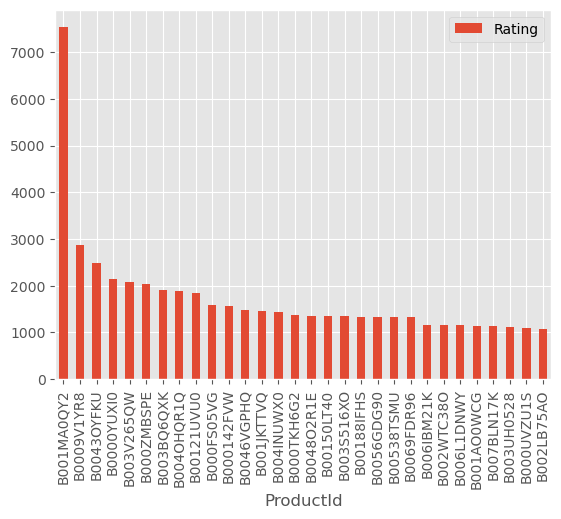

In [25]:
most_popular.head(30).plot(kind = "bar")